# Imports and Data Loading

In [36]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision import transforms
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Check Torch version
print(torch.__version__)

# Downloading and Loading MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_set = MNIST(root='./', train=True, download=True, transform=transform)
test_set = MNIST(root='./', train=False, download=True, transform=transform)

# Data Loaders and Training/Validation Split
num_workers = 0
batch_size = 128
valid_size = 0.2

# Creating data indices for training and validation splits
num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index, valid_index = indices[split:], indices[:split]

# Creating PT data samplers and loaders
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)

train_loader = DataLoader(train_set, batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = DataLoader(train_set, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)


2.1.0+cu118


# Shared Utility Functions

In [37]:
# Function Gets the number of true positives by comparing the predictions and labels
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
# Function to denormalize the image
def denormalize(tensor):
    return tensor * 0.5 + 0.5

# Models and Training


## Exercise 1 MLP Model

In [38]:
class MLP(nn.Module):
    # Inilize variables
    def __init__(self):
        super(MLP, self).__init__()
        self.Input = nn.Linear(in_features=784,out_features=512)
        self.Dropout1 = nn.Dropout(0.2)
        self.Hidden = nn.Linear(in_features=512,out_features=512)
        self.Dropout2 = nn.Dropout(0.2)
        self.Predictions = nn.Linear(in_features=512,out_features=10)
    # forward is used to describe the behavior of the model during a feed forward pass
    def forward(self, input_tensor):
        #Flatten the w and h of the image (2D --> 1D)
        x = torch.flatten(input_tensor,start_dim=1)
        x = self.Input(x)
        #Apply non linear activation function relu
        x = F.relu(x)
        x = self.Dropout1(x)
        x = self.Hidden(x)
        x = F.relu(x)
        x = self.Dropout2(x)
        x = self.Predictions(x)
        #Apply Softmax to the output of the model then return the result
        x = F.log_softmax(x, dim=1)
        return x
    # __repr__ returns the models architecture when called
    def __repr__(self):
        return super().__repr__()

### Training MLP Model Function

In [39]:
# Criterion and Optimizer
model = MLP()
optimizer = optim.RMSprop(model.parameters(),lr=0.01)
n_epochs = 20

In [40]:
for epoch in range(n_epochs):
    #Initialize scalar values to 0 at each epoch
    train_loss = 0
    val_loss = 0
    train_correct = 0
    val_correct = 0
    #Changing model state to train 
    model.train()
    for batch in train_loader: #Get batch
        images, labels = batch
        #Sets the gradients of all optimized torch.Tensors to zero.
        optimizer.zero_grad()
        preds = model(images) # Pass or forward batch
        loss = F.cross_entropy(preds, labels) # Calculate loss using cross entropy multiclass
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights
        #Add batch loss value to train loss (We want the mean)
        train_loss += loss.item() * images.size(0)
        #Add batch TP (True Positive) value to train correct (We want the mean Accuracy)
        train_correct += get_num_correct(preds, labels) 
    model.eval()
    #Get batch from validation set
    for batch in valid_loader:
        images, labels = batch
        preds = model(images)
        loss = F.cross_entropy(preds, labels)
        val_loss = loss.item() * images.size(0)
        val_correct += get_num_correct(preds, labels) 
    #Calculating the epochs values for loss acc val_loss and val_accuracy
    train_loss = train_loss / len(train_loader.sampler)
    val_loss = val_loss / len(valid_loader.sampler)
    accuracy = train_correct / len(train_loader.sampler)
    val_accuracy = val_correct / len(valid_loader.sampler)
    #Shawing the epochs scalar values
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch+1, 
        train_loss,
        val_loss,
        accuracy,
        val_accuracy
        ))


Epoch: 1 	Training Loss: 22.179486 	Validation Loss: 0.014411 	Accuracy: 0.528771 	Validation Accuracy: 0.667917
Epoch: 2 	Training Loss: 1.324737 	Validation Loss: 0.006559 	Accuracy: 0.587562 	Validation Accuracy: 0.709750
Epoch: 3 	Training Loss: 0.954925 	Validation Loss: 0.006601 	Accuracy: 0.677771 	Validation Accuracy: 0.695250
Epoch: 4 	Training Loss: 0.822693 	Validation Loss: 0.002970 	Accuracy: 0.749771 	Validation Accuracy: 0.854000
Epoch: 5 	Training Loss: 0.795302 	Validation Loss: 0.003867 	Accuracy: 0.769708 	Validation Accuracy: 0.868250
Epoch: 6 	Training Loss: 0.689851 	Validation Loss: 0.003253 	Accuracy: 0.786667 	Validation Accuracy: 0.876333
Epoch: 7 	Training Loss: 0.681502 	Validation Loss: 0.003813 	Accuracy: 0.789833 	Validation Accuracy: 0.864500
Epoch: 8 	Training Loss: 0.640617 	Validation Loss: 0.004435 	Accuracy: 0.798875 	Validation Accuracy: 0.872000
Epoch: 9 	Training Loss: 0.621391 	Validation Loss: 0.002499 	Accuracy: 0.807063 	Validation Accuracy: 

### Confusion Matrix function

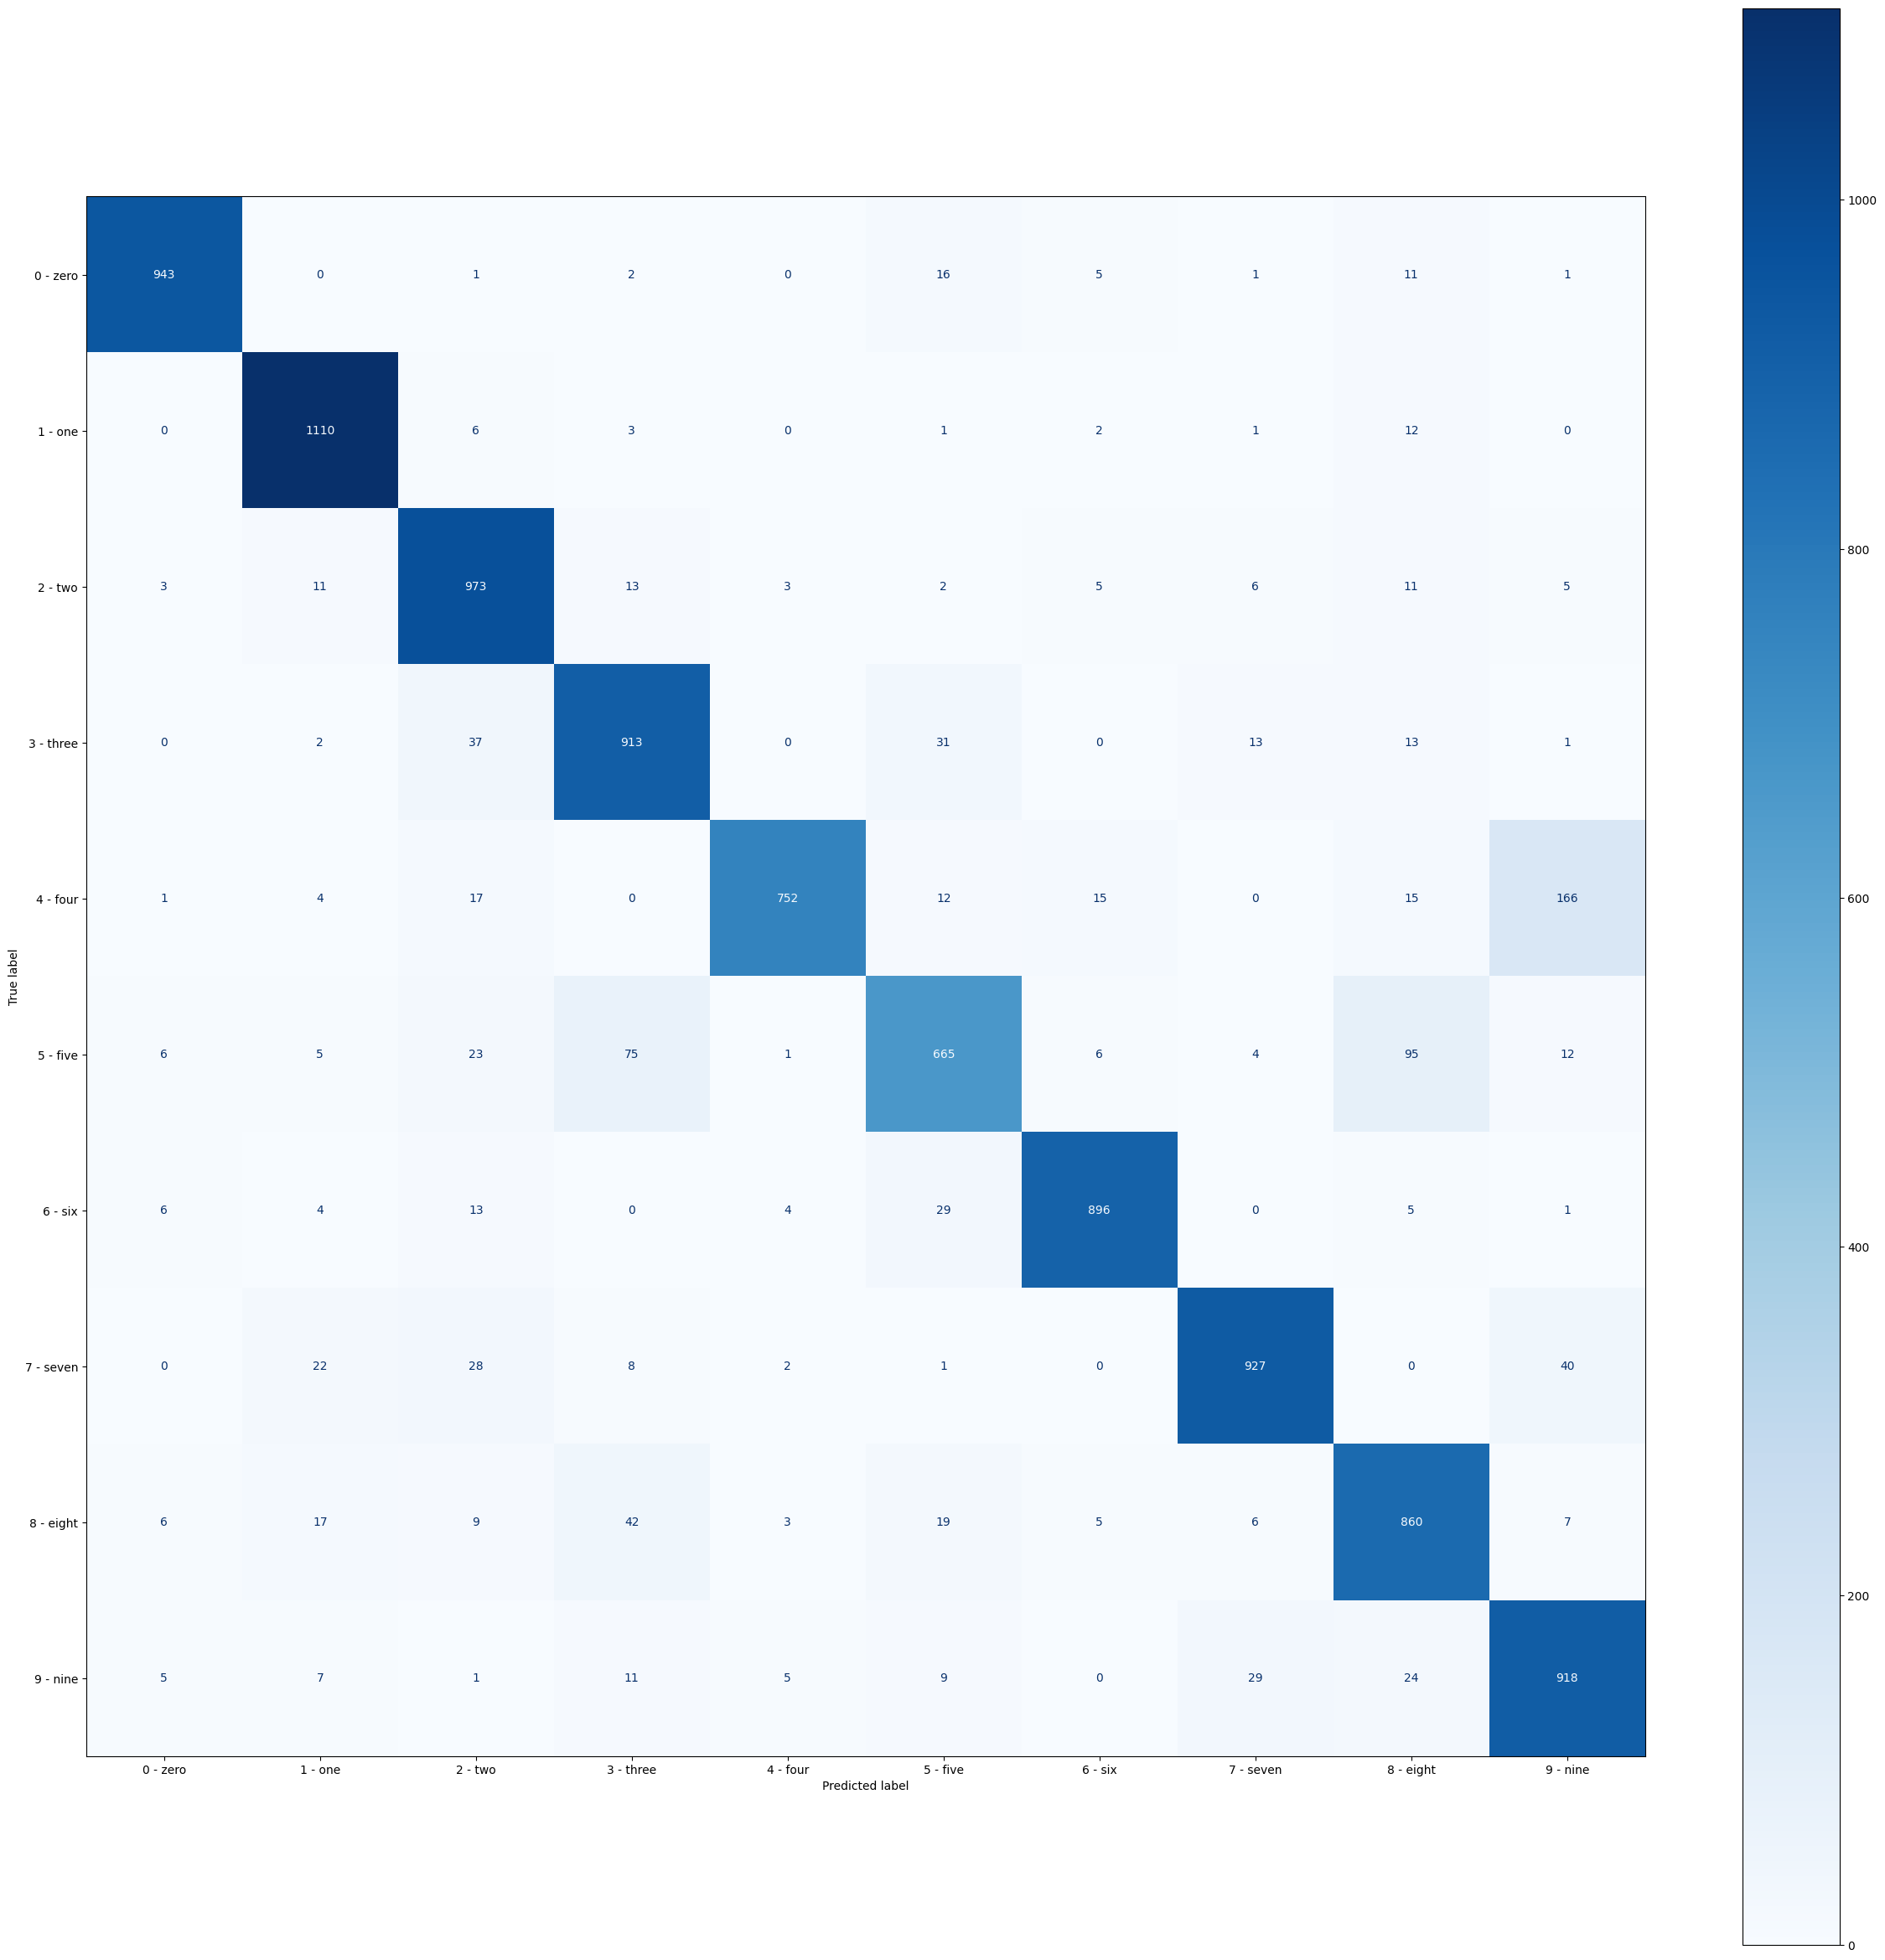

Test Loss: 0.356631

Test Accuracy of     0: 96% (943/980)
Test Accuracy of     1: 97% (1110/1135)
Test Accuracy of     2: 94% (973/1032)
Test Accuracy of     3: 90% (913/1010)
Test Accuracy of     4: 76% (752/982)
Test Accuracy of     5: 74% (665/892)
Test Accuracy of     6: 93% (896/958)
Test Accuracy of     7: 90% (927/1028)
Test Accuracy of     8: 88% (860/974)
Test Accuracy of     9: 90% (918/1009)


In [41]:
y_pred = []
y_tr = []
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval()
for batch in test_loader:
    images, labels = batch
    preds = model(images)
    y_pred.extend(np.argmax(preds.detach().numpy(), axis=1))
    y_tr.extend(labels.detach().numpy())
    loss = F.cross_entropy(preds, labels)
    test_loss += loss.item()* images.size(0)
    _, pred = torch.max(preds, 1)
    correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
    for i in range(len(labels)):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
cm = confusion_matrix(y_true=y_tr, y_pred=y_pred)
lbls = test_set.classes
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lbls)
fig, ax = plt.subplots(figsize=(30,30))
cmp.plot(cmap=plt.cm.Blues,ax=ax)
plt.show()
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))

## Exercise 2 CNN Model

In [42]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc2(x), dim=1)
        return x


In [43]:
# Criterion and Optimizer
model = CNN()
optimizer = optim.SGD(model.parameters(),lr=0.001)
n_epochs = 20

### Training the model

In [44]:
for epoch in range(n_epochs):
    #Initialize scalar values to 0 at each epoch
    train_loss = 0
    val_loss = 0
    train_correct = 0
    val_correct = 0
    #Changing model state to train 
    model.train()
    for batch in train_loader: #Get batch
        images, labels = batch
        #Sets the gradients of all optimized torch.Tensors to zero.
        optimizer.zero_grad()
        preds = model(images) # Pass or forward batch
        loss = F.cross_entropy(preds, labels) # Calculate loss using cross entropy multiclass
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights
        #Add batch loss value to train loss (We want the mean)
        train_loss += loss.item() * images.size(0)
        #Add batch TP (True Positive) value to train correct (We want the mean Accuracy)
        train_correct += get_num_correct(preds, labels) 
    model.eval()
    #Get batch from validation set
    for batch in valid_loader:
        images, labels = batch
        preds = model(images)
        loss = F.cross_entropy(preds, labels)
        val_loss = loss.item() * images.size(0)
        val_correct += get_num_correct(preds, labels) 
    #Calculating the epochs values for loss acc val_loss and val_accuracy
    train_loss = train_loss / len(train_loader.sampler)
    val_loss = val_loss / len(valid_loader.sampler)
    accuracy = train_correct / len(train_loader.sampler)
    val_accuracy = val_correct / len(valid_loader.sampler)
    #Shawing the epochs scalar values
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch+1, 
        train_loss,
        val_loss,
        accuracy,
        val_accuracy
        ))


Epoch: 1 	Training Loss: 2.290778 	Validation Loss: 0.018186 	Accuracy: 0.130875 	Validation Accuracy: 0.168083
Epoch: 2 	Training Loss: 2.253790 	Validation Loss: 0.017916 	Accuracy: 0.225104 	Validation Accuracy: 0.266000
Epoch: 3 	Training Loss: 2.203203 	Validation Loss: 0.017328 	Accuracy: 0.354500 	Validation Accuracy: 0.510417
Epoch: 4 	Training Loss: 2.118052 	Validation Loss: 0.016558 	Accuracy: 0.460437 	Validation Accuracy: 0.629833
Epoch: 5 	Training Loss: 1.975705 	Validation Loss: 0.014797 	Accuracy: 0.527271 	Validation Accuracy: 0.682167
Epoch: 6 	Training Loss: 1.750920 	Validation Loss: 0.012589 	Accuracy: 0.571146 	Validation Accuracy: 0.714667
Epoch: 7 	Training Loss: 1.467831 	Validation Loss: 0.010018 	Accuracy: 0.618479 	Validation Accuracy: 0.759250
Epoch: 8 	Training Loss: 1.205167 	Validation Loss: 0.008838 	Accuracy: 0.669104 	Validation Accuracy: 0.799500
Epoch: 9 	Training Loss: 1.000708 	Validation Loss: 0.005769 	Accuracy: 0.716771 	Validation Accuracy: 0

### Confusion Matrix

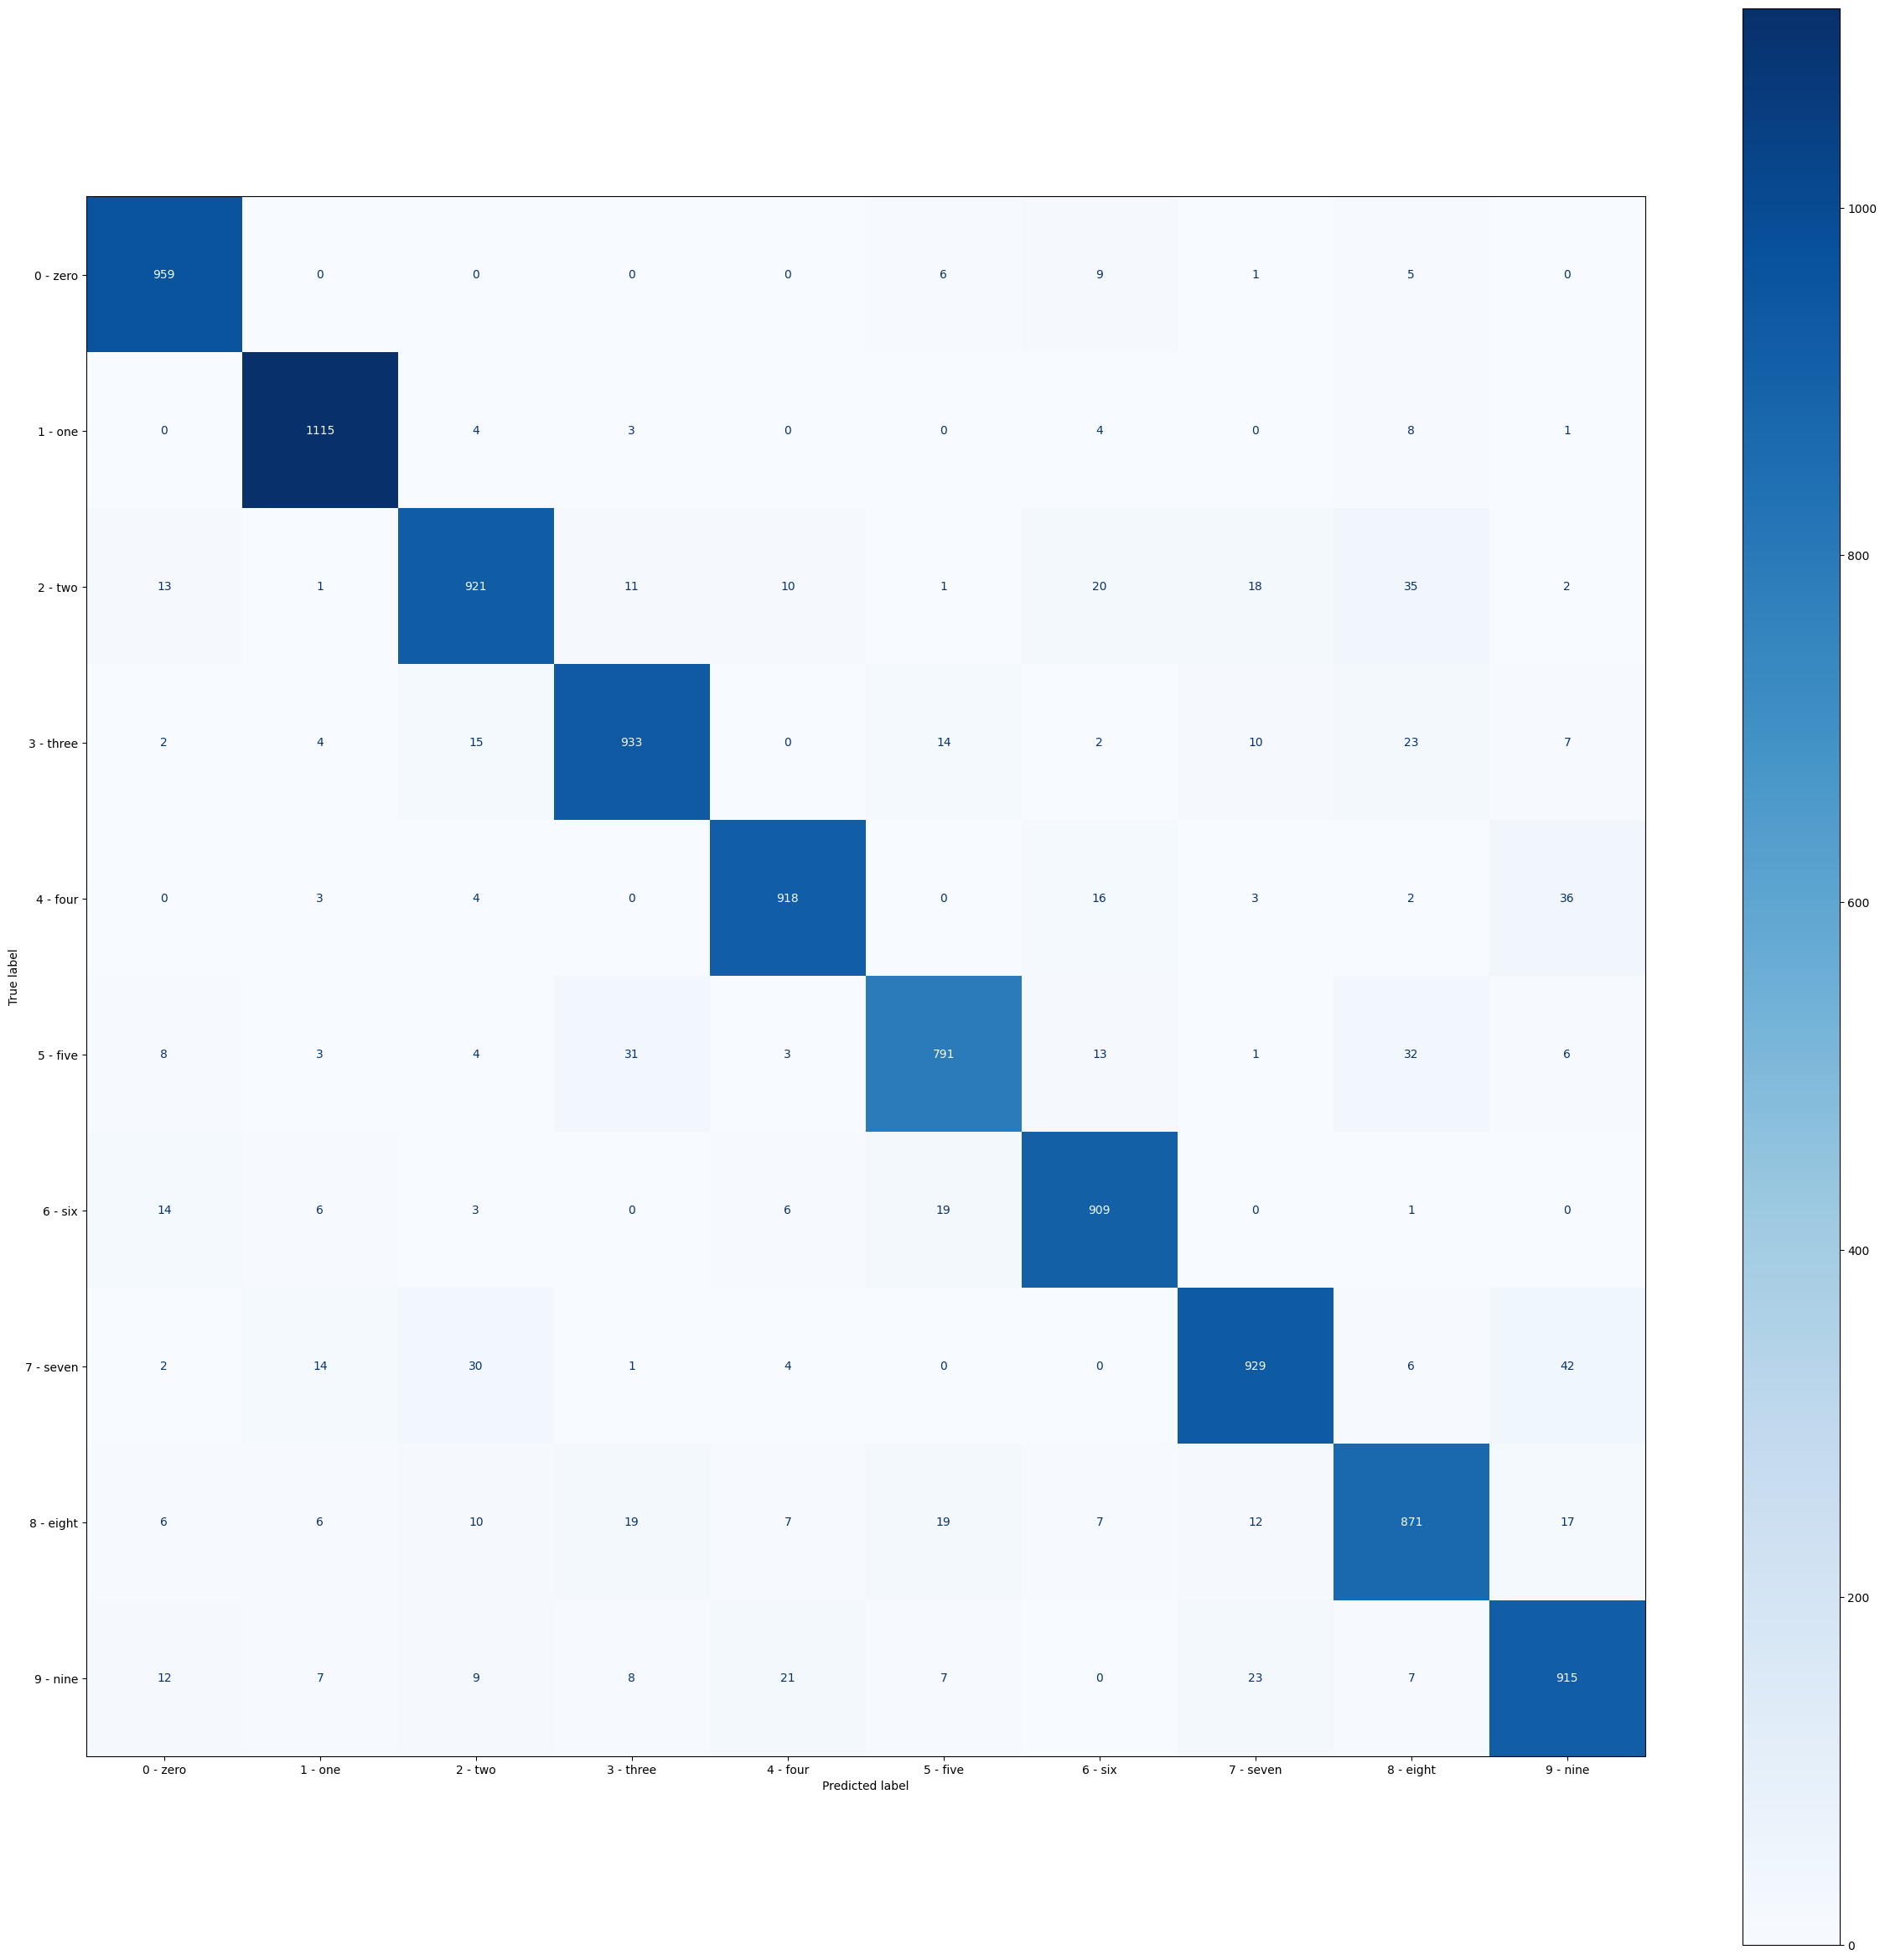

Test Loss: 0.281799

Test Accuracy of     0: 97% (959/980)
Test Accuracy of     1: 98% (1115/1135)
Test Accuracy of     2: 89% (921/1032)
Test Accuracy of     3: 92% (933/1010)
Test Accuracy of     4: 93% (918/982)
Test Accuracy of     5: 88% (791/892)
Test Accuracy of     6: 94% (909/958)
Test Accuracy of     7: 90% (929/1028)
Test Accuracy of     8: 89% (871/974)
Test Accuracy of     9: 90% (915/1009)


In [45]:
y_pred = []
y_tr = []
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval()
for batch in test_loader:
    images, labels = batch
    preds = model(images)
    y_pred.extend(np.argmax(preds.detach().numpy(), axis=1))
    y_tr.extend(labels.detach().numpy())
    loss = F.cross_entropy(preds, labels)
    test_loss += loss.item()* images.size(0)
    _, pred = torch.max(preds, 1)
    correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
    for i in range(len(labels)):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
cm = confusion_matrix(y_true=y_tr, y_pred=y_pred)
lbls = test_set.classes
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lbls)
fig, ax = plt.subplots(figsize=(30,30))
cmp.plot(cmap=plt.cm.Blues,ax=ax)
plt.show()
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))

## EXERCISE 3 Autoencoder

In [46]:
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [47]:
# Initialize the model, criterion, and optimizer
encoding_dim = 32
autoencoder = Autoencoder(encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

### Training the autoencoder

In [65]:

num_epochs = 40
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0

    # Training phase
    autoencoder.train()
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        optimizer.zero_grad()
        outputs = autoencoder(img)
        loss = criterion(outputs, img)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * img.size(0)

    # Validation phase
    autoencoder.eval()
    for data in valid_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        outputs = autoencoder(img)
        loss = criterion(outputs, img)

        val_loss += loss.item() * img.size(0)

    # Calculate average losses
    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(valid_loader.dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch: {epoch+1}/{num_epochs} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {val_loss:.6f}')

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch: 1/40 	Training Loss: 0.696155 	Validation Loss: 0.174052
Epoch: 2/40 	Training Loss: 0.696155 	Validation Loss: 0.174052
Epoch: 3/40 	Training Loss: 0.696155 	Validation Loss: 0.174052
Epoch: 4/40 	Training Loss: 0.696155 	Validation Loss: 0.174052
Epoch: 5/40 	Training Loss: 0.696155 	Validation Loss: 0.174052
Epoch: 6/40 	Training Loss: 0.696155 	Validation Loss: 0.174052
Epoch: 7/40 	Training Loss: 0.696155 	Validation Loss: 0.174052
Epoch: 8/40 	Training Loss: 0.696155 	Validation Loss: 0.174052
Epoch: 9/40 	Training Loss: 0.696155 	Validation Loss: 0.174052
Epoch: 10/40 	Training Loss: 0.696155 	Validation Loss: 0.174052
Epoch: 11/40 	Training Loss: 0.696155 	Validation Loss: 0.174052
Epoch: 12/40 	Training Loss: 0.696155 	Validation Loss: 0.174052
Epoch: 13/40 	Training Loss: 0.696155 	Validation Loss: 0.174052
Epoch: 14/40 	Training Loss: 0.696155 	Validation Loss: 0.174052
Epoch: 15/40 	Training Loss: 0.696155 	Validation Loss: 0.174052
Epoch: 16/40 	Training Loss: 0.696

### Testing the autoencoder

In [59]:
with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        encoded_imgs = autoencoder.encoder(img)
        decoded_imgs = autoencoder.decoder(encoded_imgs)

### Convert the results to NumPy arrays

In [60]:
encoded_imgs = encoded_imgs.numpy()
decoded_imgs = decoded_imgs.numpy()

### Display Original and Constructed images

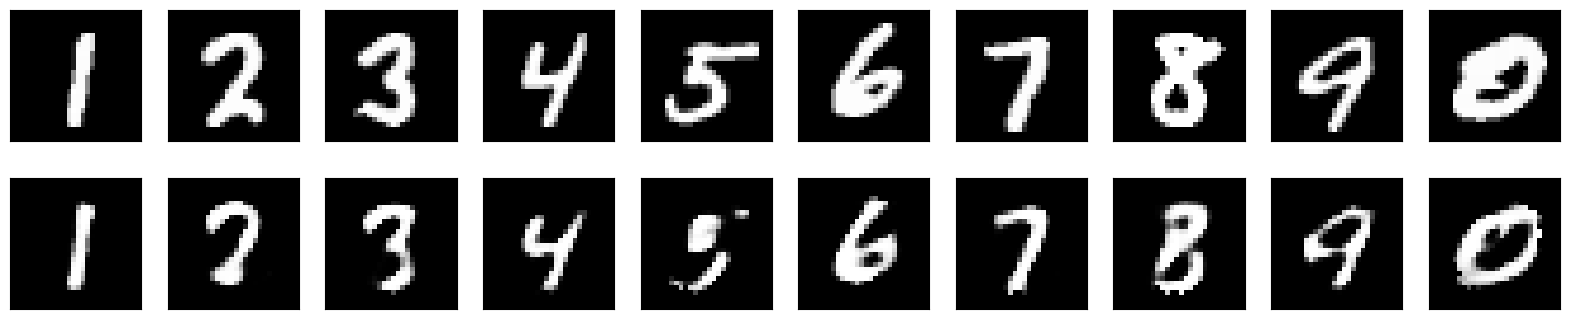

In [61]:
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))

for i in range(n):
    # Original Images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(img[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed Images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## EXERCISE 4 Convolutional Autoencoder

In [52]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=1, padding=1),  # output: 16 x 28 x 28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 16 x 14 x 14
            nn.Conv2d(16, 32, 3, stride=1, padding=1),  # output: 32 x 14 x 14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 32 x 7 x 7
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(32, 16, 3, stride=1, padding=1),  # output: 16 x 7 x 7
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),  # output: 16 x 14 x 14
            nn.Conv2d(16, 8, 3, stride=1, padding=1),  # output: 8 x 14 x 14
            nn.ReLU(),
            nn.Upsample(scale_factor=2),  # output: 8 x 28 x 28
            nn.Conv2d(8, 1, 3, stride=1, padding=1),  # output: 1 x 28 x 28
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [53]:
# criterion, model, optimizer
model = ConvAutoencoder()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 10

### Training the Convotional Autoencoder

In [58]:
import matplotlib.pyplot as plt

num_epochs = 10  # Adjust as needed
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0

    # Training phase
    model.train()
    for data in train_loader:
        img, _ = data
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * img.size(0)

    # Validation phase
    model.eval()
    for data in valid_loader:
        img, _ = data
        output = model(img)
        loss = criterion(output, img)
        val_loss += loss.item() * img.size(0)

    # Calculate average losses
    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(valid_loader.dataset)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch: {epoch+1}/{num_epochs} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {val_loss:.6f}')

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch: 1/10 	Training Loss: 0.670726 	Validation Loss: 0.167618
Epoch: 2/10 	Training Loss: 0.670611 	Validation Loss: 0.167854
Epoch: 3/10 	Training Loss: 0.670515 	Validation Loss: 0.167558
Epoch: 4/10 	Training Loss: 0.670385 	Validation Loss: 0.167553
Epoch: 5/10 	Training Loss: 0.670309 	Validation Loss: 0.167531
Epoch: 6/10 	Training Loss: 0.670220 	Validation Loss: 0.167518
Epoch: 7/10 	Training Loss: 0.670140 	Validation Loss: 0.167541
Epoch: 8/10 	Training Loss: 0.670059 	Validation Loss: 0.167464
Epoch: 9/10 	Training Loss: 0.670017 	Validation Loss: 0.167492
Epoch: 10/10 	Training Loss: 0.669907 	Validation Loss: 0.167441


### Testing the autoencoder

In [62]:

# Set the model to evaluation mode
model.eval()

# Get a batch of test images
test_images, _ = next(iter(test_loader))

# Generate reconstructed images
with torch.no_grad():
    reconstructed_images = model(test_images)

# Apply denormalization
test_images = denormalize(test_images)
reconstructed_images = denormalize(reconstructed_images)


### Ploting the original and reconstructed imagese

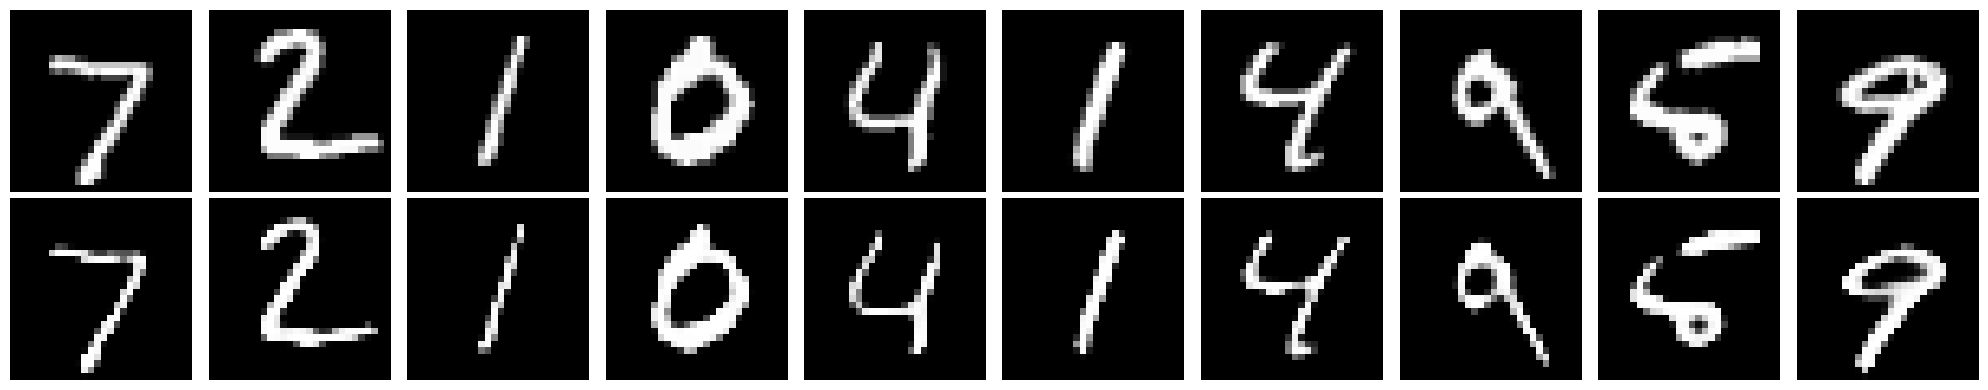

In [63]:

# Plot the original and reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 4))

# Plot original images
for i in range(10):
    axes[0, i].imshow(test_images[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')

# Plot reconstructed images
for i in range(10):
    axes[1, i].imshow(reconstructed_images[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()
